<a href="https://colab.research.google.com/github/uliebal/iUL959/blob/master/iUL959_JupyterNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Genome scale model reconstruction of the methylotrophic yeast Ogataea polymorpha: Reproduction of simulations of iUL959 with CobraPy Notebook

## Introduction

This notebook is an extension to the article by Liebal et al., (2019) and reproduces the comparison of experimental growth rates with predictions by the genome scale metabolic model (GSMM) of Ogataea polymorpha iUL959.


## Requirements

Make sure that the required files are present in the notebook. Only dependencies not already present in the jupyter/scipy-noteboook are listed (see here for the default list: https://jupyter-docker-stacks.readthedocs.io/en/latest/using/selecting.html) 

Files:
* iUL959.xml: SBML file, Genome scale metabolic model of O. polymorpha
* iUL959_GSMM-addinfo.xlsx: Excel file, contains the literature growth rates and uptake rate in sheet 'Literature_Chemostat'


## Set-up compute environment 

In the following cell the python environment is set up. If CobraPy and Memote are not already downloaded, use the following command to download the packages them from the cell:
!{sys.executable} -m pip install cobra

In [0]:
import sys # loading commands to control/navigate within the system architecture
# Loading pandas, a library for data manipulation
#!{sys.executable} -m pip install pandas
import pandas as pd
import xlrd

# Loading numpy, a library fo manipulation of numbers
import numpy as np

# loading matplotlib, a library for visualization
!{sys.executable} -m pip install matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# loading cobrapy, a library dedicated to the analysis of genome scale metabolic models
!{sys.executable} -m pip install cobra
from cobra.io import read_sbml_model
from cobra.io import write_sbml_model


## Data loading

Now, the external data is integrated. In Google, you can use the upload link below. For Binder, upload them manually. The excel-sheet is parsed and the GSMM file is converted to a model variable.

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

## Data manipulation

In [0]:
myxls = 'iUL959_GSMM-addinfo.xlsx'
x1 = pd.ExcelFile(myxls)
print(x1.sheet_names)
df1 = x1.parse('Literature_Chemostat')
df1.head(9)


In [0]:
# generating cobra variable from SBML/xml file
model = read_sbml_model('iUL959.xml')
model

## Function definitions

We are testing three different growth conditions with substrates methanol, glycerol, and glucose. For each of the substrates, the corresponding exchange rate has to be activated, the approriate biomass composition formula has to be selected and exchange reactions for non-used substrates need to be closed.

In [0]:
def AdaptMethanol(model, meoh_up):
  # setting uptake reactions right
  model.reactions.Ex_glc_D.lower_bound = 0
  model.reactions.Ex_glyc.lower_bound = 0
  model.reactions.Ex_meoh.lower_bound = -np.abs(meoh_up)
  # setting additional biomass composition
  model.reactions.LIPIDS_meoh.upper_bound = 1000
  model.reactions.PROTEINS_meoh.upper_bound = 1000
  model.reactions.STEROLS_meoh.upper_bound = 1000
  model.reactions.BIOMASS_meoh.upper_bound = 1000
  # deactivating Glc-based biomass composition
  model.reactions.LIPIDS.upper_bound = 0
  model.reactions.PROTEINS.upper_bound = 0
  model.reactions.STEROLS.upper_bound = 0
  model.reactions.BIOMASS.upper_bound = 0  
  model.objective = 'BIOMASS_meoh'
  return model

def AdaptGlucose(model, glc_up):
  # setting uptake reactions right
  model.reactions.Ex_meoh.lower_bound = 0
  model.reactions.Ex_glyc.lower_bound = 0
  model.reactions.Ex_glc_D.lower_bound = -np.abs(glc_up)
  # setting additional biomass composition
  model.reactions.LIPIDS.upper_bound = 1000
  model.reactions.PROTEINS.upper_bound = 1000
  model.reactions.STEROLS.upper_bound = 1000
  model.reactions.BIOMASS.upper_bound = 1000  
  # deactivating Glc-based biomass composition
  model.reactions.LIPIDS_meoh.upper_bound = 0
  model.reactions.PROTEINS_meoh.upper_bound = 0
  model.reactions.STEROLS_meoh.upper_bound = 0
  model.reactions.BIOMASS_meoh.upper_bound = 0
  model.objective = 'BIOMASS'
  return model

def AdaptGlycerol(model, glyc_up):
  # setting uptake reactions right
  model.reactions.Ex_meoh.lower_bound = 0;
  model.reactions.Ex_glc_D.lower_bound = 0;
  model.reactions.Ex_glyc.lower_bound = -np.abs(glyc_up)
  # setting additional biomass composition
  model.reactions.LIPIDS.upper_bound = 1000
  model.reactions.PROTEINS.upper_bound = 1000
  model.reactions.STEROLS.upper_bound = 1000
  model.reactions.BIOMASS_glyc.upper_bound = 1000  
  # deactivating Glc-based biomass composition
  model.reactions.LIPIDS_meoh.upper_bound = 0
  model.reactions.PROTEINS_meoh.upper_bound = 0
  model.reactions.STEROLS_meoh.upper_bound = 0
  model.reactions.BIOMASS_meoh.upper_bound = 0
  model.objective = 'BIOMASS_glyc'
  return model


## Simulation and visualization

Here, we start the simulation loop. For all substrates we use the substrate uptake rate and use the functions defined previously to update the model. The final growth rate is stored, and is then used in a plot versus the experimentally observed growth.

In [0]:
test_model = model.copy()
growth_simulated = [];
for index, row in df1.iterrows():
  print(index)
  if row['Substrate'] == 'Methanol':
    test_model = AdaptMethanol(test_model, row['uptake rate (mmol/gCDW/h)'])
  elif row['Substrate'] == 'Glucose':
    test_model = AdaptGlucose(test_model, row['uptake rate (mmol/gCDW/h)'])
  elif row['Substrate'] == 'Glycerol':
    test_model = AdaptGlycerol(test_model, row['uptake rate (mmol/gCDW/h)'])
  else:
    print('substrate not considered')      
  test_model.optimize()
  growth_simulated.append(test_model.objective.value)


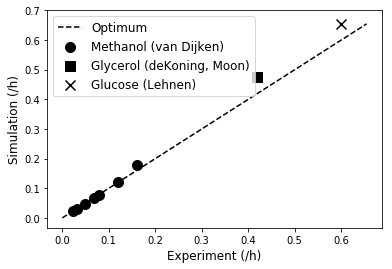

In [9]:
plt.rc('axes', labelsize=12) 
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plt.rc('legend', fontsize=12) 
# plt.figure(figsize=(4,3))
plt.scatter(df1['growth rate (/h)'][1:8], growth_simulated[1:8], s=100, c='k', marker='o', );
plt.scatter(df1['growth rate (/h)'][8], growth_simulated[8], s=100, c='k', marker='s');
plt.scatter(df1['growth rate (/h)'][0], growth_simulated[0], s=100, c='k', marker='x');
plt.xlabel('Experiment (/h)');
plt.ylabel('Simulation (/h)');
myline = np.linspace(0,np.max(growth_simulated),10);
plt.plot(myline,myline,'k--');
# plt.title('Growth rate comparison');
plt.legend(['Optimum','Methanol (van Dijken)','Glycerol (deKoning, Moon)','Glucose (Lehnen)'], loc=2);
plt.style.use('seaborn-paper')
plt.savefig('iOpol_growth_exp-vs-sim.png', bbox_inches='tight')
# plt.savefig('iOpol_growth_exp-vs-sim.pdf', bbox_inches='tight')


### Adding reactions for itaconate production

In [0]:
from cobra.core import Reaction, Model, Metabolite

Model_itaconate = model.copy()

# assuming that citrate is in quick equilibrium with aconitate to ignore this reaction
# first reaction is the conversion of cytoplasmic citrate to itaconate
# itaconate is exported and exchanged
reaction1 = Reaction('CAD')
reaction1.name = 'cis-aconitate decarboxylase'
reaction1.lower_bound = 0.
reaction1.upper_bound = 1000.
#reaction1.objective_coefficient = 0
reaction1.reaction_reversibility = 0

R1metCit = Model_itaconate.metabolites.get_by_id('cit__91__c__93__')
R1metCO2 = Model_itaconate.metabolites.get_by_id('co2__91__c__93__')
R1metIta = Metabolite('Ita_c', name='Itaconate, cytoplasm', formula='C5H6O4', compartment='c')
reaction1.add_metabolites({R1metCit: -1.0,
                           R1metCO2: 1.0,
                           R1metIta: 1.0})

# for testing purpose we add the exchange reaction directly to the cytoplasmic itaconate
reaction2 = Reaction('Ex_ita')
reaction2.name = 'Exchange, itaconate cytoplasm'
reaction2.lower_bound = 0.
reaction2.upper_bound = 1000.
#reaction2.objective_coefficient = 0
reaction2.reaction_reversibility = 1
reaction2.add_metabolites({R1metIta: -1.0})

Model_itaconate.add_reactions([reaction1, reaction2])
# Model_itaconate.reactions.get_by_id('Ex_ita')


### Testing itaconate production

In [0]:
Model_itaconate.objective = 'Ex_ita'
Model_itaconate.optimize()
Model_itaconate.summary()